### This script require a GPU to work

In [1]:

import pandas as pd
import bambi as bmb
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format

df = pd.read_csv('unseen_species_model/individuals_into_unseen_plus_>3.csv')

df["count"] = df["count_works"]
df_m = df.copy()
df_m = df_m[df_m["count"].isin({0, 1, 2})]  # Not more ?
df_m["y"] = df_m["count"].map({0: 0, 1: 0, 2: 1})

WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
df_distribution = df_m[['individual_wikidata_id','occupation']].drop_duplicates()
df_distribution.occupation.value_counts()

occupation
Writer               53007
Painter              23878
Musician             14757
Architect             7539
Sculptor              6953
Performing Artist     3229
Name: count, dtype: int64

In [3]:
df_count_work_model = df_m.copy()
df_count_work_model['count_works'][df_count_work_model['count_works']==0] = 1
df_count_work_model = df_count_work_model.groupby(['region_name'])['count_works'].sum().reset_index()
df_count_work_model = df_count_work_model.rename(columns = {'count_works':'count_works_f1_f2'})

In [4]:
# knots
num_knots = 10
knots = np.linspace(df["century"].min(), df["century"].max(), num_knots)
iknots = knots[1:-1]

sample = df_m.copy()
#sample = sample.sample(20000, random_state=42)

In [5]:
print(len(set(sample.individual_wikidata_id)))

109363


In [6]:
sample.region_name.value_counts()

region_name
Northwestern Europe    71086
German world           29339
Southwestern Europe    20237
France                 17841
Italy                  14225
United Kingdom         10689
Central Europe          8500
Low countries           7233
Nordic countries        5414
Spain                   5026
East Slavic             3919
Chinese world           1504
Arabic world            1202
Greek World             1103
Japan                    949
Portugal                 718
Persian world            475
Indian world             412
Southern China           320
Latin World              294
Southern Japan           235
Northern China           188
Korea                    179
Northern Japan           155
Name: count, dtype: int64

In [ ]:
#MODEL 3
equation = 'y ~ bs(decade, knots=iknots, intercept=True) + occupation +(1|region_name)'
# SECOND MODEL
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=5),
    "common": bmb.Prior("Normal", mu=0, sigma=5),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=5))
}

base_model = bmb.Model(
    equation, 
    sample, 
    family='bernoulli', 
    priors=priors)


base_model_fitted = base_model.fit(
    draws=1000,
    chains=4,
    inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True},
)  # important to run faster and sample more efficiently


In [ ]:
# import pickle

# # Save the fitted model to a file
# with open('base_model_fitted_north_south.pkl', 'wb') as file:
#     pickle.dump(base_model_fitted, file)


# import pickle


# # Load the fitted model from a file
# with open('base_model_fitted_north_south.pkl', 'rb') as file:
#     base_model_fitted = pickle.load(file)

In [ ]:
az.summary(base_model_fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-3.01,1.48,-5.90,-0.32,0.06,0.04,604.00,873.00,1.01
"bs(decade, knots=iknots, intercept=True)[0]",1.77,2.25,-2.53,5.86,0.07,0.05,1201.00,1908.00,1.00
"bs(decade, knots=iknots, intercept=True)[1]",-0.07,1.98,-3.59,3.75,0.06,0.04,1014.00,1844.00,1.01
"bs(decade, knots=iknots, intercept=True)[2]",-0.19,1.65,-3.28,2.99,0.06,0.04,727.00,1142.00,1.01
"bs(decade, knots=iknots, intercept=True)[3]",0.09,1.56,-2.75,3.04,0.06,0.04,653.00,1047.00,1.01
"bs(decade, knots=iknots, intercept=True)[4]",-0.21,1.52,-3.03,2.65,0.06,0.04,631.00,1019.00,1.01
"bs(decade, knots=iknots, intercept=True)[5]",1.13,1.51,-1.96,3.72,0.06,0.04,645.00,939.00,1.01
"bs(decade, knots=iknots, intercept=True)[6]",-0.73,1.51,-3.41,2.29,0.06,0.04,618.00,869.00,1.01
"bs(decade, knots=iknots, intercept=True)[7]",0.41,1.49,-2.46,3.12,0.06,0.04,616.00,952.00,1.01
"bs(decade, knots=iknots, intercept=True)[8]",-0.23,1.48,-2.78,2.77,0.06,0.04,603.00,896.00,1.01


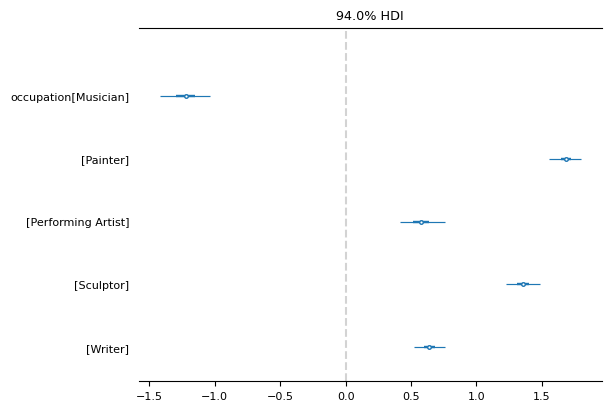

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)

az.plot_forest(
    data=base_model_fitted,
    var_names=["occupation"],
    r_hat=False,
    combined=True,
    textsize=8,
    ess=False,
    ax=ax
)

# fig = forest_plot[0].get_figure()
# fig.set_size_inches(8, 4)  # Adjust size as needed
# fig.tight_layout()
# fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)

plt.axvline(0, c='lightgrey', ls='--')
#fig.savefig("results/occupation/forest_plot.png")

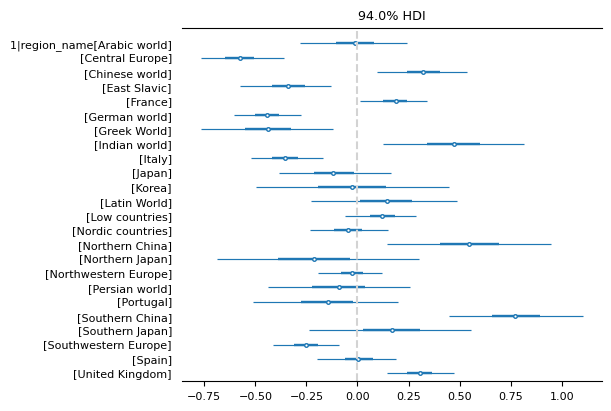

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)

az.plot_forest(
    data=base_model_fitted,
    var_names=["1|region_name"],
    r_hat=False,
    combined=True,
    textsize=8,
    ess=False,
    ax=ax
)

# fig = forest_plot[0].get_figure()
# fig.set_size_inches(8, 4)  # Adjust size as needed
# fig.tight_layout()
# fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)

plt.axvline(0, c='lightgrey', ls='--')
#fig.savefig("results/occupation/forest_plot.png")

In [ ]:
#region = 'France'
#occupation = 'Architecture'
new_data = {}

#data = df_m[df_m["region_name"] == region]
data = df_m.copy()
new_data["decade"] = data["decade"].values
new_data["occupation"] = data["occupation"].values
new_data["region_name"] =  data["region_name"].values

new_data = pd.DataFrame(new_data)

base_model.predict(base_model_fitted, data=new_data)
posterior_stacked = az.extract(base_model_fitted)
#p = posterior_stacked['y_mean'].values

y_hat = posterior_stacked["y_mean"].values
y_mean = y_hat.mean(axis=1)
hdi_data = np.quantile(y_hat, [0.11, 0.89], axis=1)

In [ ]:
# Création du dataset

data['y_mean'] = y_mean
data['y_min'] = hdi_data[0]
data['y_max'] = hdi_data[1]

def compute_f0(p):
    l = (2 * p) / (1 - p)
    f0 = 1 / (l + (l**2) / 2)
    return f0

def compute_f1(y):
    if y ==0:
        return 1
    else:
        return 0

def compute_f2(y):
    if y == 1:
        return 1
    else:
        return 0

data['f0'] = data['y_mean'].apply(lambda x : compute_f0(x))
data['max_f0'] = data['y_min'].apply(lambda x : compute_f0(x))
data['min_f0'] = data['y_max'].apply(lambda x : compute_f0(x))

data['f1'] = data['y'].apply(compute_f1)
data['f2'] = data['y'].apply(compute_f2)

#data.to_csv(PATH + '/raw_results_north_south_china.csv')
data.to_csv('unseen_species_model/unseen_species_model_bayesian.csv')